0001196096 Antonelli Giacomo giacomo.antonelli4@studio.unibo.it

0001153900 Chevokin Nikita nikita.chevokin@studio.unibo.it

# Assignment Module 2: Pet Classification

The goal of this assignment is to implement a neural network that classifies images of 37 breeds of cats and dogs from the [Oxford-IIIT-Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). The assignment is divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.

In [1]:
from pathlib import Path
import os
import time
import copy
from typing import List, Tuple, Dict
from pprint import pprint

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np, torch
from dataclasses import dataclass, asdict
import pandas as pd
import math, random, gc
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import amp, Tensor
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import OneCycleLR, LambdaLR
from torchvision import transforms

from google.colab import drive
from torchvision.models import resnet18, ResNet18_Weights

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Torch optimizations
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

# Set randomness fixed for reproducibility
seed = 42
random.seed(seed);
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Dataset

The following cells contain the code to download and access the dataset you will be using in this assignment. Note that, although this dataset features each and every image from [Oxford-IIIT-Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/), it uses a different train-val-test split than the original authors.

In [3]:
!git clone https://github.com/CVLAB-Unibo/ipcv-assignment-2.git

Cloning into 'ipcv-assignment-2'...
remote: Enumerating objects: 7371, done.
remote: Total 7371 (delta 0), reused 0 (delta 0), pack-reused 7371 (from 1)
Receiving objects: 100% (7371/7371), 753.77 MiB | 40.30 MiB/s, done.
Updating files: 100% (7396/7396), done.


In [9]:
class OriginalOxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

# Standard values for CNNs data augmentation
RESIZE_SIZE = 256
IMAGE_SIZE = 224

standard_transforms = transforms.Compose([
    transforms.Resize(RESIZE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor()
])

data_transforms = {
    'train': standard_transforms,
    'val': standard_transforms,
    'test': standard_transforms
}

image_datasets_original = {
    'train': OriginalOxfordPetDataset(split='train', transform=data_transforms['train']),
    'val': OriginalOxfordPetDataset(split='val', transform=data_transforms['val']),
    'test': OriginalOxfordPetDataset(split='test', transform=data_transforms['test'])
}

dataloaders_original = {
    x: DataLoader(image_datasets_original[x], batch_size=32, shuffle=(x=='train'), num_workers=2)
    for x in ['train', 'val', 'test']
}

dataset_sizes = {x: len(image_datasets_original[x]) for x in ['train', 'val', 'test']}
num_classes = image_datasets_original['train'].get_num_classes()

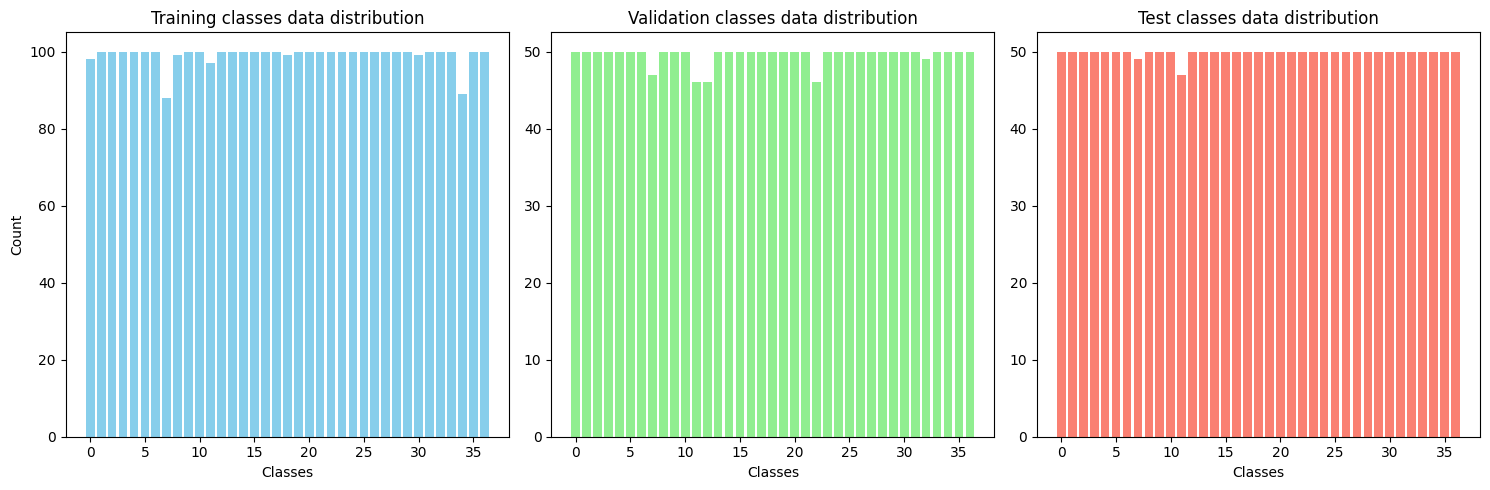

In [ ]:
train_classes, counter_training_class = np.unique(image_datasets_original["train"].labels, return_counts=True)
validation_classes, counter_validation_class = np.unique(image_datasets_original["val"].labels, return_counts=True)
test_classes, counter_test_class = np.unique(image_datasets_original["test"].labels, return_counts=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(train_classes, counter_training_class, color='skyblue')
axes[0].set_title("Training classes data distribution")
axes[0].set_xlabel("Classes")
axes[0].set_ylabel("Count")

axes[1].bar(validation_classes, counter_validation_class, color='lightgreen')
axes[1].set_title("Validation classes data distribution")
axes[1].set_xlabel("Classes")

axes[2].bar(test_classes, counter_test_class, color='salmon')
axes[2].set_title("Test classes data distribution")
axes[2].set_xlabel("Classes")

plt.tight_layout()
plt.show()


The following cell instead, downloads an augmented version of the dataset, which has been manually cleaned to remove poor-quality generations after an augmentation process consisting of normalization, resizing and flipping.

In [10]:
!git clone https://huggingface.co/datasets/IGieckI/Oxford-Pet-Augmented-checked

Cloning into 'Oxford-Pet-Augmented-checked'...
remote: Enumerating objects: 28641, done.
remote: Total 28641 (delta 0), reused 0 (delta 0), pack-reused 28641 (from 1)
Receiving objects: 100% (28641/28641), 4.00 MiB | 9.55 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (28657/28657), done.
Filtering content: 100% (28652/28652), 998.98 MiB | 5.50 MiB/s, done.


In [11]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()
        self.root = Path("Oxford-Pet-Augmented-checked")
        self.split = split
        self.transform = transform

        self.names, self.labels = self._get_names_and_labels()

        # build a map: image name -> actual path across all part directories
        img_root = self.root / "images_split"
        parts = sorted([p for p in img_root.iterdir() if p.is_dir() and p.name.startswith("part")])
        name_to_path = {}
        for part in parts:
            for jpg in part.glob("*.jpg"):
                name_to_path[jpg.stem] = jpg
        self.name_to_path = name_to_path

        # Filter missing files (keep only items that physically exist)
        keep_names, keep_labels, missing = [], [], []
        for n, l in zip(self.names, self.labels):
            if n in self.name_to_path:
                keep_names.append(n); keep_labels.append(l)
            else:
                missing.append(n)

        if missing:
            print(f"[{split}] filtered out {len(missing)} missing files. Example(s): {missing[:3]}")

        self.names = keep_names
        self.labels = keep_labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        name = self.names[idx]
        img_path = self.name_to_path[name]
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self):
      names, labels_raw = [], []
      with open(self.root / "annotations" / f"{self.split}.txt") as f:
          for line in f:
              name, lab = line.strip().split(" ")
              names.append(name)
              labels_raw.append(int(lab))

      # Make sure that annotations are 0..36, and not 1..37 (for cross-entropy)
      mn, mx = min(labels_raw), max(labels_raw)

      if mn == 1 and mx == 37:
          labels_raw = [l - 1 for l in labels_raw]

      return names, labels_raw

# Data Augmentation and Transformation
# IMPORTANT NOTE: The augmentations over the dataset have been commented out, as the augmentation process has been
# already done (then saved on the huggingface link) and the bad generations cleaned, such that the only necessity is the ToTensor() transformation
data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(RESIZE_SIZE),
        #transforms.RandomResizeCrop(IMAGE_SIZE),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'val': standard_transforms,
    'test': standard_transforms
}

image_datasets = {
    'train': OxfordPetDataset(split='train', transform=data_transforms['train']),
    'val': OxfordPetDataset(split='val', transform=data_transforms['val']),
    'test': OxfordPetDataset(split='test', transform=data_transforms['test'])
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=(x=='train'), num_workers=2)
    for x in ['train', 'val', 'test']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
num_classes = image_datasets['train'].get_num_classes()

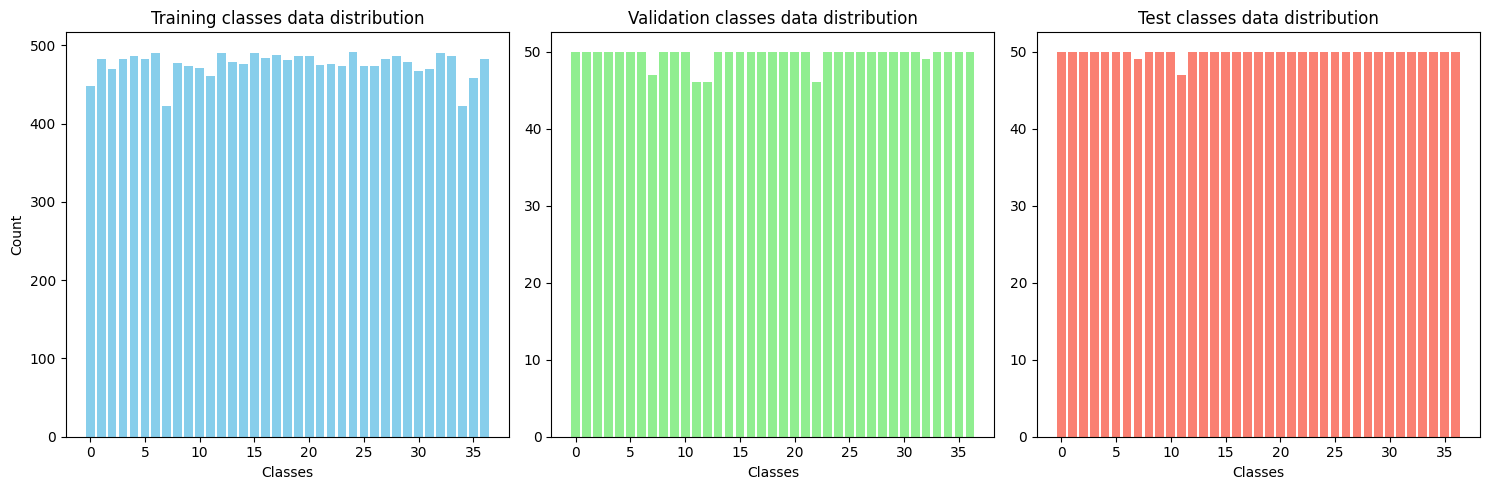

In [ ]:
train_classes, counter_training_class = np.unique(image_datasets["train"].labels, return_counts=True)
validation_classes, counter_validation_class = np.unique(image_datasets["val"].labels, return_counts=True)
test_classes, counter_test_class = np.unique(image_datasets["test"].labels, return_counts=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(train_classes, counter_training_class, color='skyblue')
axes[0].set_title("Training classes data distribution")
axes[0].set_xlabel("Classes")
axes[0].set_ylabel("Count")

axes[1].bar(validation_classes, counter_validation_class, color='lightgreen')
axes[1].set_title("Validation classes data distribution")
axes[1].set_xlabel("Classes")

axes[2].bar(test_classes, counter_test_class, color='salmon')
axes[2].set_title("Test classes data distribution")
axes[2].set_xlabel("Classes")

plt.tight_layout()
plt.show()


We can see from the plots that all datasets have a uniform class distribution, because of this, we will use plain accuracy as the evaluation metric for our models.

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it from scratch on `OxfordPetDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~60%. You are free to achieve this however you want, except for a few rules you must follow:

- Compile this notebook by displaying the results obtained by the best model you found throughout your experimentation; then show how, by removing some of its components, its performance drops. In other words, do an *ablation study* to prove that your design choices have a positive impact on the final result.

- Do not instantiate an off-the-self PyTorch network. Instead, construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you cannot use e.g. `torchvision.models.alexnet`.

- Show your results and ablations with plots, tables, images, etc. — the clearer, the better.

Don't be too concerned with your model performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded more points than a poorly experimentally validated model with higher accuracy.

## Model Design

A critical design decision in this project was the adoption of a residual network architecture rather than a plain convolutional stack. The Oxford Pet dataset presents a moderate challenge: the classes are relatively fine-grained, with breeds that are visually similar, yet the dataset is not large enough to reliably train very deep models without strong regularization, in such a setting, conventional deep CNNs are prone to optimization difficulties, particularly the vanishing gradient problem, where error signals diminish as they propagate through multiple layers.

Residual connections directly address this impediment by introducing identity shortcuts.They enable gradients to flow unimpeded across multiple layers. This as a consequence brings forth another so very beneficial implication, the network can be both deep and more expressive without incurring training instability and unnecessary risks. Furthermore, pre-activation residual blocks stand out as a tremendous architectural advent in the present regard further stabilising optimisation, they normalise activations prior to convolution, which has been empirically shown to improve convergence behaviour.

In this implementation, a Pre-Activated Residual Block ([Kaiming's paper  2016](https://arxiv.org/abs/1603.05027)) has been used instead of the original or Bottleneck version, seen in the lectures. In this version, the pre-activation design places batch normalization and ReLU layers before the convolutional operations, this has been shown in the paper's results, to improve gradient flow and ease optimization, leading often to better convergence and generalization performance without significantly increasing computational cost.

In [11]:
class PreActBasicBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        # Each convolution is preceded by Batch normalisation
        # BN normalises feature maps channel-wise, stabilising the distribution of activations and gradients
        self.bn1  = nn.BatchNorm2d(in_ch) # downsample
        self.conv1= nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1, bias=False)
        self.bn2  = nn.BatchNorm2d(out_ch) # no downsampling
        self.conv2= nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1, bias=False)
        self.proj = None
        # In a residual block the output is computed as the sum of the result of the two convolutional layers and the identity path.
        # For this addition to work, the shapes must match precisely (same number of channels and same spatial resolution)
        # The following situations break the alignment:
        # 1) if stride=2 in conv1, the residual branch halves the spatial resolution.
        # 2) Channel expansion (in_ch != out_ch)
        # if the block increases channel count for instance from 64 to 128, the residual branch transmutes into (N, 128, Height, Width)
        # Even so, the shortcut remain intact, hence channel dimensions differ
        # So we use 1x1 convolution which changes only the channel dimension as well as downsamples
        # the shortcut to correspond to the residual branch
        if stride != 1 or in_ch != out_ch:
            self.proj = nn.Conv2d(in_ch, out_ch, 1, stride=stride, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x), inplace=True))
        out = self.conv2(F.relu(self.bn2(out), inplace=True))
        shortcut = x if self.proj is None else self.proj(x)
        return F.relu(out + shortcut, inplace=True)

def make_layer(block, in_ch, out_ch, num_blocks, stride_first):
    layers = [block(in_ch, out_ch, stride=stride_first)]
    # the remaining blocks (always use stride 1 to retain spatial resolution)
    for _ in range(1, num_blocks):
        layers.append(block(out_ch, out_ch, stride=1))
    return nn.Sequential(*layers)

CustomResNet comprises of 4 stages that crescively downsample and widen channels, we have also add a width multiplier to control capacity and cost. Normally, pursuant to the literature, ResNets use fixed channel counts at each stage: 64-128-256-512. In our implementation we decided to scale those canonical number by a factor (width).
Wider networks have more parameters, hence in such a scenario we would likely have higher accuracy yet slower training, conversely, for all narrower ones provide faster training and less memory consumption, they are known to be quite susceptible to underfitting. Given the latter, then it stands to reason that adjustement of 'width' counteracts a possible effect of underfitting together and, as a consequence, unstable accuracy with computation usage.

In the very inception of the model set-up, we used a stem block according to the general practice. Despite the commonplace approach, we also opted for some different advancement, unlike the original ResNet, this design keeps the first convolution small (just 3x3) and non-downsampling, this preserves fine-grained spatial detail from the very outset.

In [12]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes=37, depths=(2,2,2,2), width=0.75):
        super().__init__()
        w = lambda c: max(8, int(round(c * width)))

        self.stem = nn.Sequential(
            nn.Conv2d(3, w(64), 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(w(64)),
            nn.ReLU(inplace=True),)
        self.layer1 = make_layer(PreActBasicBlock,  w(64),  w(64),  depths[0], stride_first=1)
        self.layer2 = make_layer(PreActBasicBlock,  w(64),  w(128), depths[1], stride_first=2)
        self.layer3 = make_layer(PreActBasicBlock, w(128), w(256), depths[2], stride_first=2)
        self.layer4 = make_layer(PreActBasicBlock, w(256), w(512), depths[3], stride_first=2)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(w(512), num_classes)

        # Weights initialization using the kaiming distribution (useful in computer vision tasks)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.pool(x)
        x = torch.flatten(x, 1)

        # ensure the FC matches what we have
        if x.shape[1] != self.fc.in_features:
            raise RuntimeError(
                f"FC in_features={self.fc.in_features}, but got tensor with {x.shape[1]} features.")
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
print(f"Device: {device}")
print({k: len(v) for k,v in image_datasets.items()})
print("Num classes:", num_classes)

baseline_model = CustomResNet(num_classes=num_classes, depths=(2,2,2,2), width=1.0).to(device).to(memory_format=torch.channels_last)
n_params = sum(p.numel() for p in baseline_model.parameters())
print(f"Params: {n_params/1e6:.2f} M")

xb, yb = next(iter(dataloaders['train']))
print("Batch:", tuple(xb.shape), tuple(yb.shape), "dtype:", xb.dtype)

del baseline_model
torch.cuda.empty_cache()

Device: cuda
{'train': 17594, 'val': 1834, 'test': 1846}
Num classes: 37
Params: 11.19 M
Batch: (32, 3, 224, 224) (32,) dtype: torch.float32


## Baseline Model Summary

**Dataset & splits:** OxfordPetDataset (`train/val/test` fixed) with 37-classes.

### Model
- Custom ResNet (`CustomResNet`), blocks: `PreActBasicBlock`
- Depths: (2, 2, 2, 2) • Width: 1.0 • Dropout: 0.2
- AdaptiveAvgPool - Linear(num_classes)

### Training
- Epochs: 40 with Batch size of 32
- Optimiser: AdamW (lr max = 3e-3, weight_decay = 3e-4)
- Scheduler: OneCycleLR (per-step)
- Loss: CrossEntropy + label smoothing = 0.05
- Grad clipping: 1.0 and Mixed precision (AMP) on
- Memory format: channels_last

### Data pipeline
- **Train:** Resize(256) - RandomResizedCrop(224) - RandomHorizontalFlip - ToTensor
- **Val/Test:** Resize(256) - CenterCrop(224) - ToTensor

### Reproducibility
- Seed = 42, fixed splits; metric = top-1 accuracy (val for selection, test for final report).


## Model Training

**MAX_GRAD_NORM**: in deep networks, especially with residual connections, sometimes gradients can become very large. It leads to unstable updates which hurts the model performance. So we decided to apply **gradient_clipping** - it rescales the gradient if the total norm surpasses a threshold. 1 is a conventional choice.

**SCHEDULER_PER_STEP**: required for OneCycle

In [5]:
MAX_GRAD_NORM      = 1.0
SCHEDULER_PER_STEP = True

Several strategies were combined to make training both faster and more reliable.

First and foremost, automatic mixed precision was utilies so that most operations could run in hal precision, saving memory and boosting speed, while still applying loss scaling to obviate numerical issues, this was paired with the channels-last memory format, which allows convolutional layers to run more efficiently.

Data handling was also optimised: by enabling asynchronous transfer, batches can be moved to the GPU while the CPU is already preparing the successive one, curtailing waiting time.

To keep training stable in the view of these speed-ups, gradient clipping was applid to cap extreme updates and preclude instabilities in optimisation. Additionally, checkpoinitng was introduced so that the model, optimiser, and scheduler states could be saved at each epoch, makikng it possible to resume training precisely from it left off.

In [ ]:
def train_model(model: nn.Module,
                dataloaders: Dict[str, DataLoader],
                criterion: nn.Module,
                optimizer: optim.Optimizer,
                scheduler: optim.lr_scheduler._LRScheduler,
                num_epochs: int = 30,
                start_epoch: int = 0,
                ckpt_path: str = None) -> Tuple[nn.Module, Dict[str, list], int]:

    use_amp = torch.cuda.is_available()
    scaler  = amp.GradScaler(enabled=use_amp)

    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(start_epoch, num_epochs):
        print("-" * 20)
        print(f'Epoch {epoch+1}/{num_epochs}')

        for phase in ['train', 'val']:
            # model accumulators
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            running_corrects = 0
            seen = 0

            for inputs, labels in dataloaders[phase]:
                # faster memory format on many GPUs
                # moves the batch of images from CPU to GPU
                inputs = inputs.to(device, non_blocking=True).to(memory_format=torch.channels_last)

                # if "labels" is a tuple it's kept on device but compute accuracy against labels[0]
                # when we use Mixup / Cutmix each training example is a blend of 2 images and their labels
                # To avert ambiguity, it is a general practice to pick one of the original lables when computing accuracy
                # it keeps metrics comparable since the validation set distribute the real accuracy anyway
                if isinstance(labels, tuple):
                    labels = tuple(t.to(device, non_blocking=True) if torch.is_tensor(t) else t for t in labels)
                    labels_for_acc = labels[0]
                else:
                    labels = labels.to(device, non_blocking=True)
                    labels_for_acc = labels

                optimizer.zero_grad(set_to_none=True)

                # Train phase: gradients are captured and refined
                # Val phase: gradients disabled and no backpropagation needed
                with torch.set_grad_enabled(phase == 'train'):
                    # autocast runs certain operations in float16 whilst
                    # keeping sensitive ones in float32
                    with amp.autocast(device_type='cuda', enabled=use_amp):
                        # FORWARD PASS + LOSS
                        outputs = model(inputs)
                        loss = criterion(outputs, labels_for_acc)

                    # BACKPROPAGATION
                    if phase == 'train':
                        # if the loss or gradients are negligibly small, they may underflow to 0 -> Vanishing Gradient
                        # hence we scale before backward pass (then we'll unscale before the optimiser step)

                        scaler.scale(loss).backward()
                        scaler.unscale_(optimizer)
                        # Prevents exploading gradients
                        clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
                        # optimiser step with the scaled gradients
                        scaler.step(optimizer)
                        scaler.update()

                        # step LR per-batch, but never exceed the configured total_steps
                        if scheduler is not None and SCHEDULER_PER_STEP:
                            # OneCycleLR tracks how many times it's been stepped with _step_count
                            # and exposes the configured total via .total_steps
                            if getattr(scheduler, "_step_count", 0) < scheduler.total_steps:
                                scheduler.step()

                # metrics
                preds = outputs.argmax(1).detach()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (preds == labels_for_acc).sum().item()
                seen += inputs.size(0)

            # mean loss and accuracy per epoch
            epoch_loss = running_loss / max(1, seen)
            epoch_acc  = running_corrects / max(1, seen)

            # History logs
            # train metrics
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
                if scheduler is not None and not SCHEDULER_PER_STEP:
                    scheduler.step()
            else:
                # Records validation metrics
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    # we also need to trace the best model, so we hoard up weights
                    # whenever validation accuracy improves
                    best_model_wts = copy.deepcopy(model.state_dict())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # save checkpoint after each epoch
        if ckpt_path is not None:
            torch.save({
                "epoch": epoch,
                "model": model.state_dict(),
                "opt": optimizer.state_dict(),
                "sched": None if scheduler is None else scheduler.state_dict(),
                "scaler": scaler.state_dict(),
                "best_acc": best_acc,
                "best_wts": best_model_wts,
            }, ckpt_path)

    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history, epoch

def evaluate_model(model: nn.Module, dataloader: DataLoader) -> float:
    model.eval()
    running_corrects = 0
    with torch.no_grad(): # disable gradienrt tracking for evaluation
        for inputs, labels in dataloader:
            inputs = inputs.to(device, non_blocking=True).to(memory_format=torch.channels_last)
            labels = labels.to(device, non_blocking=True)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) # taking the highest probability class per sample
            running_corrects += torch.sum(preds == labels)
    accuracy = running_corrects.double() / len(dataloader.dataset)
    return accuracy.item()

def plot_history(history: Dict[str, list], title: str):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy'); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
    plt.suptitle(title)
    plt.show()

To initialise the training phase, the Google Drive environment was mounted in order to provide persistent storage for model checkpoints and best-performing weights, this safeguarding progress against Colab runtime interruptions.

In [10]:
# Parameters
NUM_CLASSES = 37
NUM_EPOCHS  = 40
LEARNING_RATE = 3e-3
MAX_LEARNING_RATE  = LEARNING_RATE * 2
WEIGHT_DECAY       = 3e-4
LABEL_SMOOTHING    = 0.05
WIDTH_MULTIPLIER   = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# To save last checkpoint and best weights
MODEL_DIR = '/content/drive/MyDrive/colab_models'
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_SAVE_PATH = os.path.join(MODEL_DIR, f'custom_resnet_weights_baseline.pth')
CKPT_PATH = os.path.join(MODEL_DIR, f'custom_resnet_baseline_last.ckpt')

In [14]:
# build model
model = CustomResNet(num_classes=37, depths=(2,2,2,2),
                 width=WIDTH_MULTIPLIER).to(device)

# Here we convert model tensors to channel_lasts for GPU efficacy
# channel_lasts is said to better align with hardware expectations
# leading to lower memory bandwith pressure
# Also may make potential imporevement in training speed of around 10-20%
model = model.to(memory_format=torch.channels_last)

# resumes if a checkpoint exists
ckpt = None
start_epoch = 0
best_acc_resume = None

criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer_custom = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

steps_per_epoch = len(dataloaders['train'])
total_steps = steps_per_epoch * NUM_EPOCHS

s = None

if os.path.isfile(CKPT_PATH):
    s = torch.load(CKPT_PATH, map_location=device)

    try:
        model.load_state_dict(s["model"], strict=True)
        start_epoch = int(s.get("epoch", -1)) + 1
        best_acc_resume = s.get("best_acc", None)
        print(f"Resumed from {CKPT_PATH} at epoch {start_epoch} (best_acc={best_acc_resume})")
    except Exception as e:
        print(f"Could not fully resume: {e}")

    # resume optimiser
    try:
        if "opt" in s:
            optimizer_custom.load_state_dict(s["opt"])
    except Exception as e:
        print(f"Opt resume failed: {e}")

# ensure initial_lr exists BEFORE creating OneCycleLR
for g in optimizer_custom.param_groups:
    g.setdefault('initial_lr', g['lr'])

# figure out how many batch-steps were already done
start_epoch = s.get("epoch", -1) + 1 if s is not None else 0
done_steps  = start_epoch * steps_per_epoch

scheduler = OneCycleLR(
    optimizer_custom,
    max_lr=MAX_LEARNING_RATE,
    total_steps=total_steps,
    last_epoch=done_steps - 1  # align with resume point if not loading sched state
)

# if the scheduler state has been saved, prefer loading it (ignoring last_epoch above)
if s is not None and s.get("sched") is not None:
    try:
        scheduler.load_state_dict(s["sched"])
    except Exception as e:
        print(f"Scheduler resume failed: {e}")

--------------------
Epoch 1/40
train Loss: 3.3570 Acc: 0.0989
val Loss: 3.2884 Acc: 0.1140
--------------------
Epoch 2/40
train Loss: 3.0726 Acc: 0.1695
val Loss: 3.0849 Acc: 0.1794
--------------------
Epoch 3/40
train Loss: 2.8788 Acc: 0.2263
val Loss: 3.2495 Acc: 0.1701
--------------------
Epoch 4/40
train Loss: 2.6882 Acc: 0.2780
val Loss: 3.3828 Acc: 0.1565
--------------------
Epoch 5/40
train Loss: 2.5240 Acc: 0.3264
val Loss: 2.7329 Acc: 0.2950
--------------------
Epoch 6/40
train Loss: 2.3621 Acc: 0.3818
val Loss: 2.7798 Acc: 0.3233
--------------------
Epoch 7/40
train Loss: 2.1504 Acc: 0.4396
val Loss: 2.5626 Acc: 0.3773
--------------------
Epoch 8/40
train Loss: 1.9656 Acc: 0.5037
val Loss: 2.7839 Acc: 0.3288
--------------------
Epoch 9/40
train Loss: 1.7885 Acc: 0.5622
val Loss: 2.1665 Acc: 0.4444
--------------------
Epoch 10/40
train Loss: 1.6483 Acc: 0.6125
val Loss: 2.0603 Acc: 0.5245
--------------------
Epoch 11/40
train Loss: 1.5189 Acc: 0.6558
val Loss: 2.101

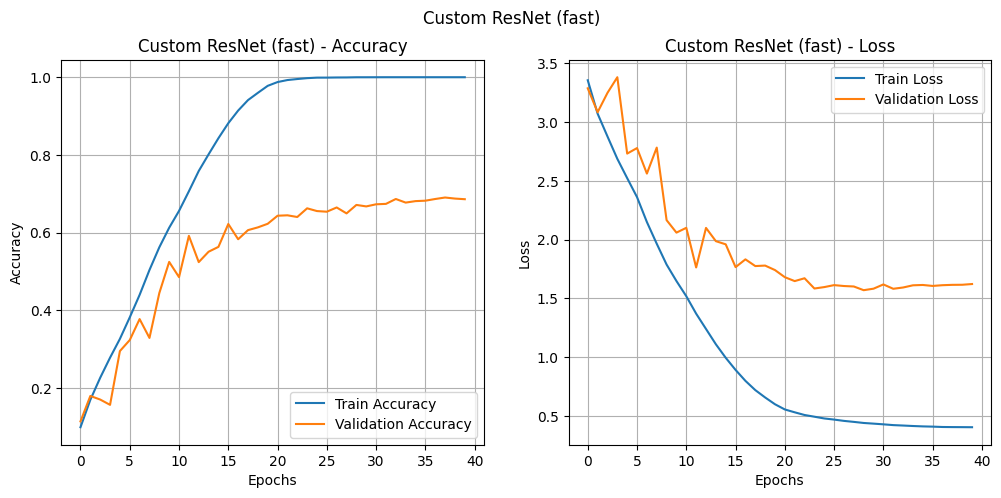

Model - Test Acc: 0.71398


In [ ]:
model, history, last_epoch_idx = train_model(model, dataloaders, criterion,
                                             optimizer_custom, scheduler,
                                             num_epochs=NUM_EPOCHS,
                                             start_epoch=start_epoch,
                                             ckpt_path=CKPT_PATH)

# Save best weights
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

# PLot Training istory
plot_history(history, "Custom ResNet (fast)")

# Evaluate on test set
test_acc = evaluate_model(model, dataloaders['test'])
print(f"Model - Test Acc: {test_acc:.5f}")

# Performance

*   Final Validation Accuracy: 0.714
*   Training time: 148 minutes
*   Validation loss: does not improve significantly after epoch 25  
*   Training accuracy: 100% by epoch 23 onwards
*   Validation accuracy: plateaus around 0.66 - 0.67
From the mentioned above, we can infer heavy overfitting. Training accuracy soars up to 100%, yet validation accuracy forestalled at around 67%. The gap between train acc (1.00) and val acc (0.67) points to overfitting.

The CustomResNet architecture + no pretrainig ensues that it memorised training images rather than learning strong general features.
This motivates the use of a pretrained backbone in Part 2, where we observe substantially stronger generalisation and much faster convergence.


# Ablation Study
This section conducts an ablation studies to evaluate the impact of key architectural components on the ResNet model's performance, we systematically remove or modify one component at a time: Batch Normalization, residual connections, dropout, and data augmentation, while keeping other parameters consistent with the baseline.

Each experiment trains a modified model on the same dataset, reports validation and test accuracies, and visualizes training dynamics to assess the contribution of each component to overall performance.

## Ablation study 1 - Disable of Batch Norm


--- Starting Ablation Study 1: No BatchNorm ---
--------------------
Epoch 1/40
train Loss: 3.5758 Acc: 0.0363
val Loss: 3.5150 Acc: 0.0502
--------------------
Epoch 2/40
train Loss: 3.4373 Acc: 0.0728
val Loss: 3.5114 Acc: 0.0545
--------------------
Epoch 3/40
train Loss: 3.3981 Acc: 0.0797
val Loss: 3.4608 Acc: 0.0649
--------------------
Epoch 4/40
train Loss: 3.3709 Acc: 0.0897
val Loss: 3.3905 Acc: 0.0812
--------------------
Epoch 5/40
train Loss: 3.3498 Acc: 0.0986
val Loss: 3.3864 Acc: 0.0894
--------------------
Epoch 6/40
train Loss: 3.2744 Acc: 0.1190
val Loss: 3.2728 Acc: 0.1189
--------------------
Epoch 7/40
train Loss: 3.1932 Acc: 0.1432
val Loss: 3.1760 Acc: 0.1516
--------------------
Epoch 8/40
train Loss: 3.0157 Acc: 0.1852
val Loss: 2.9885 Acc: 0.2039
--------------------
Epoch 9/40
train Loss: 2.8130 Acc: 0.2458
val Loss: 2.8012 Acc: 0.2726
--------------------
Epoch 10/40
train Loss: 2.6205 Acc: 0.2993
val Loss: 2.6710 Acc: 0.2983
--------------------
Epoch 11/

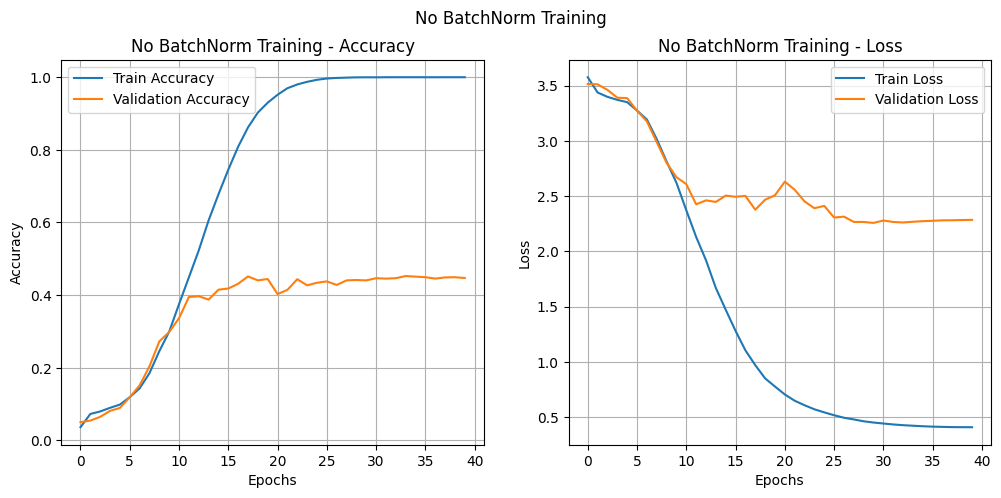

Ablation No BN - Test Acc: 0.51300


In [ ]:
# Made a custom version of the previous network without BatchNorm
class PreActBasicBlockNoBN(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        # Use bias=True since there's no BN layer to provide bias
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1, bias=True)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1, bias=True)
        self.proj = None
        if stride != 1 or in_ch != out_ch:
            self.proj = nn.Conv2d(in_ch, out_ch, 1, stride=stride, bias=True)

    def forward(self, x):
        out = self.conv1(F.relu(x))
        out = self.conv2(F.relu(out))
        shortcut = x if self.proj is None else self.proj(x)

        return F.relu(out + shortcut)

def make_layer_no_bn(block, in_ch, out_ch, num_blocks, stride_first):
    layers = [block(in_ch, out_ch, stride=stride_first)]
    for _ in range(1, num_blocks):
        layers.append(block(out_ch, out_ch, stride=1))
    return nn.Sequential(*layers)

class CustomResNetNoBN(nn.Module):
    def __init__(self, num_classes=37, depths=(2,2,2,2), width=1.0):
        super().__init__()
        w = lambda c: max(8, int(round(c * width)))
        self.stem = nn.Sequential(
            nn.Conv2d(3, w(64), 3, stride=1, padding=1, bias=True),
            nn.ReLU(inplace=False),
        )

        self.layer1 = make_layer_no_bn(PreActBasicBlockNoBN, w(64), w(64), depths[0], stride_first=1)
        self.layer2 = make_layer_no_bn(PreActBasicBlockNoBN, w(64), w(128), depths[1], stride_first=2)
        self.layer3 = make_layer_no_bn(PreActBasicBlockNoBN, w(128), w(256), depths[2], stride_first=2)
        self.layer4 = make_layer_no_bn(PreActBasicBlockNoBN, w(256), w(512), depths[3], stride_first=2)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(w(512), 37)

        for m in self.modules():
             if isinstance(m, nn.Conv2d):
                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                 if m.bias is not None:
                     nn.init.constant_(m.bias, 0)
             elif isinstance(m, nn.Linear):
                 nn.init.normal_(m.weight, 0, 0.01)
                 if m.bias is not None:
                     nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
steps_per_epoch = len(dataloaders['train'])

# Train the model without BN
model_no_bn = CustomResNetNoBN(num_classes=37, width=1.0).to(device).to(memory_format=torch.channels_last)
optimizer_no_bn = optim.AdamW(model_no_bn.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

for g in optimizer_no_bn.param_groups:
    g.setdefault('initial_lr', g['lr'])

scheduler_no_bn = OneCycleLR(optimizer_no_bn, max_lr=MAX_LEARNING_RATE, total_steps=NUM_EPOCHS * steps_per_epoch)

print("\n--- Starting Ablation Study 1: No BatchNorm ---")
CKPT_NOBN_PATH = os.path.join(MODEL_DIR, f'custom_resnet_NOBN.ckpt')
model_no_bn, history_no_bn, last_epoch_idx_no_bn = train_model(
    model_no_bn, dataloaders, criterion, optimizer_no_bn, scheduler_no_bn, num_epochs=NUM_EPOCHS, start_epoch=0, ckpt_path=CKPT_NOBN_PATH
)

# Print results
best_val_acc_no_bn = max(history_no_bn['val_acc']) if history_no_bn['val_acc'] else 0.0
print(f"Ablation No BN - Best val Acc: {best_val_acc_no_bn:.5f}")

plot_history(history_no_bn, "No BatchNorm Training")

test_acc_no_bn = evaluate_model(model_no_bn, dataloaders['test'])
print(f"Ablation No BN - Test Acc: {test_acc_no_bn:.5f}")

## Ablation Study 2 - Removal of One, Two or Three ResBlocks

In [ ]:
# Made a custom version of the previous network to easily remove each layer by changing the new num_max_layers parameter
class CustomResizeableResNet(nn.Module):
    def __init__(self, num_classes=37, depths=(2,2,2,2), width=0.75, num_max_layers=4):
        super().__init__()
        w = lambda c: max(8, int(round(c * width)))
        self.num_max_layers = min(max(num_max_layers, 1), 4)

        self.stem = nn.Sequential(
            nn.Conv2d(3, w(64), 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(w(64)),
            nn.ReLU(inplace=True),)
        self.layer1 = make_layer(PreActBasicBlock,  w(64),  w(64),  depths[0], stride_first=1)
        last_size = 64
        if self.num_max_layers >= 2:
            self.layer2 = make_layer(PreActBasicBlock,  w(64),  w(128), depths[1], stride_first=2)
            last_size = 128
        if self.num_max_layers >= 3:
            self.layer3 = make_layer(PreActBasicBlock, w(128), w(256), depths[2], stride_first=2)
            last_size = 256
        if self.num_max_layers >= 4:
            self.layer4 = make_layer(PreActBasicBlock, w(256), w(512), depths[3], stride_first=2)
            last_size = 512

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(w(last_size), num_classes)

        # Weights initialization using the kaiming distribution (useful in computer vision tasks)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        if self.num_max_layers >= 2:
            x = self.layer2(x)
        if self.num_max_layers >= 3:
            x = self.layer3(x)
        if self.num_max_layers >= 4:
            x = self.layer4(x)

        x = self.pool(x)
        x = torch.flatten(x, 1)

        if x.shape[1] != self.fc.in_features:
            raise RuntimeError(
                f"FC in_features={self.fc.in_features}, but got tensor with {x.shape[1]} features.")
        x = self.dropout(x)
        x = self.fc(x)
        return x

--------------------
Epoch 1/40
train Loss: 3.4120 Acc: 0.0876
val Loss: 3.3469 Acc: 0.0976
--------------------
Epoch 2/40
train Loss: 3.1955 Acc: 0.1396
val Loss: 3.2070 Acc: 0.1396
--------------------
Epoch 3/40
train Loss: 3.0667 Acc: 0.1715
val Loss: 3.5605 Acc: 0.1101
--------------------
Epoch 4/40
train Loss: 2.9241 Acc: 0.2102
val Loss: 3.8115 Acc: 0.1129
--------------------
Epoch 5/40
train Loss: 2.7943 Acc: 0.2497
val Loss: 3.3821 Acc: 0.2007
--------------------
Epoch 6/40
train Loss: 2.6751 Acc: 0.2772
val Loss: 3.2145 Acc: 0.2437
--------------------
Epoch 7/40
train Loss: 2.5204 Acc: 0.3225
val Loss: 4.8096 Acc: 0.1881
--------------------
Epoch 8/40
train Loss: 2.3796 Acc: 0.3605
val Loss: 2.7285 Acc: 0.3070
--------------------
Epoch 9/40
train Loss: 2.2333 Acc: 0.4121
val Loss: 4.0828 Acc: 0.2454
--------------------
Epoch 10/40
train Loss: 2.1095 Acc: 0.4492
val Loss: 2.5309 Acc: 0.3877
--------------------
Epoch 11/40
train Loss: 1.9855 Acc: 0.4912
val Loss: 2.664

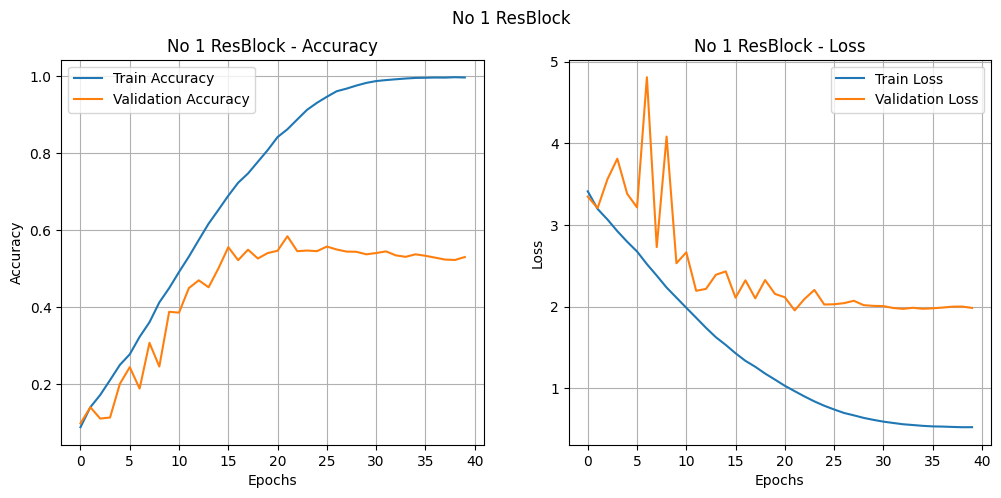

Ablation Without One ResBlock - Test Acc: 0.59859


In [ ]:
# Train the model without one ResBlock
model_no_1_res = CustomResizeableResNet(num_classes=num_classes, num_max_layers=3).to(device).to(memory_format=torch.channels_last)
optimizer_no_1_res = optim.AdamW(model_no_1_res.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler_no_1_res = OneCycleLR(optimizer_no_1_res, max_lr=MAX_LEARNING_RATE, epochs=NUM_EPOCHS, steps_per_epoch=steps_per_epoch)

model_no_1_res, history_no_1_res, best_val_acc_no_1_res = train_model(
    model_no_1_res, dataloaders, criterion, optimizer_no_1_res, scheduler_no_1_res, num_epochs=NUM_EPOCHS
)
print(f"Ablation Without One ResBlock - Best val Acc: {best_val_acc_no_1_res:.5f}")
plot_history(history_no_1_res, "No 1 ResBlock")

test_acc_no_1_res = evaluate_model(model_no_1_res, dataloaders['test'])
print(f"Ablation Without One ResBlock - Test Acc: {test_acc_no_1_res:.5f}")

--------------------
Epoch 1/40
train Loss: 3.4925 Acc: 0.0685
val Loss: 3.4471 Acc: 0.0911
--------------------
Epoch 2/40
train Loss: 3.3483 Acc: 0.1023
val Loss: 3.3596 Acc: 0.0992
--------------------
Epoch 3/40
train Loss: 3.2712 Acc: 0.1213
val Loss: 3.3345 Acc: 0.1150
--------------------
Epoch 4/40
train Loss: 3.2214 Acc: 0.1328
val Loss: 3.5190 Acc: 0.0938
--------------------
Epoch 5/40
train Loss: 3.1389 Acc: 0.1535
val Loss: 3.3531 Acc: 0.0998
--------------------
Epoch 6/40
train Loss: 3.0382 Acc: 0.1828
val Loss: 3.3084 Acc: 0.1336
--------------------
Epoch 7/40
train Loss: 2.9398 Acc: 0.2093
val Loss: 3.5391 Acc: 0.1379
--------------------
Epoch 8/40
train Loss: 2.8421 Acc: 0.2339
val Loss: 5.4697 Acc: 0.1178
--------------------
Epoch 9/40
train Loss: 2.7351 Acc: 0.2620
val Loss: 3.3550 Acc: 0.1707
--------------------
Epoch 10/40
train Loss: 2.6451 Acc: 0.2927
val Loss: 3.3712 Acc: 0.1663
--------------------
Epoch 11/40
train Loss: 2.5591 Acc: 0.3130
val Loss: 2.932

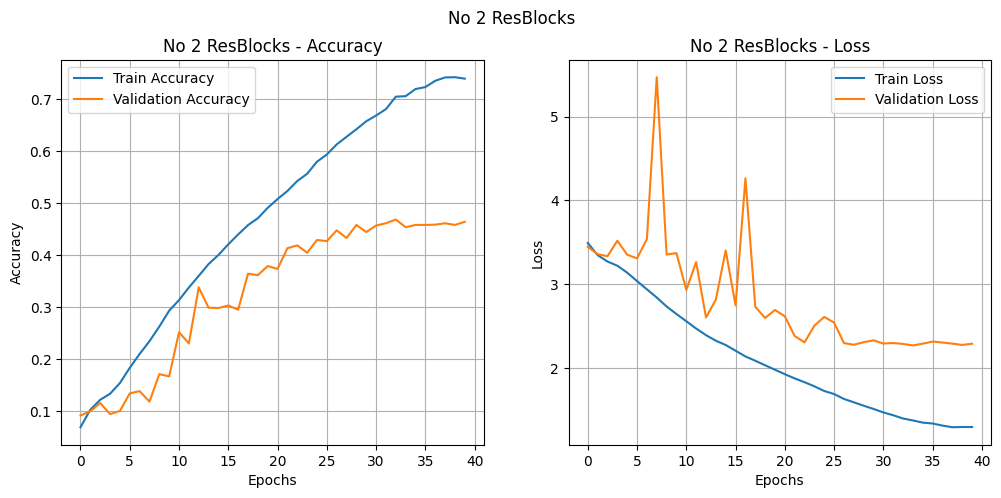

Ablation Without Two ResBlocks - Test Acc: 0.49946


In [ ]:
# Train the model without two ResBlocks
model_no_2_res = CustomResizeableResNet(num_classes=num_classes, num_max_layers=2).to(device).to(memory_format=torch.channels_last)
optimizer_no_2_res = optim.AdamW(model_no_2_res.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler_no_2_res = OneCycleLR(optimizer_no_2_res, max_lr=MAX_LEARNING_RATE, epochs=NUM_EPOCHS, steps_per_epoch=steps_per_epoch)

model_no_2_res, history_no_2_res, best_val_acc_no_2_res = train_model(
    model_no_2_res, dataloaders, criterion, optimizer_no_2_res, scheduler_no_2_res, num_epochs=NUM_EPOCHS
)
print(f"Ablation Without Two ResBlocks - Best val Acc: {best_val_acc_no_2_res:.5f}")
plot_history(history_no_2_res, "No 2 ResBlocks")

test_acc_no_2_res = evaluate_model(model_no_2_res, dataloaders['test'])
print(f"Ablation Without Two ResBlocks - Test Acc: {test_acc_no_2_res:.5f}")

--------------------
Epoch 1/40
train Loss: 3.5689 Acc: 0.0456
val Loss: 3.5062 Acc: 0.0736
--------------------
Epoch 2/40
train Loss: 3.4501 Acc: 0.0805
val Loss: 3.4303 Acc: 0.0862
--------------------
Epoch 3/40
train Loss: 3.3777 Acc: 0.0933
val Loss: 3.4752 Acc: 0.0687
--------------------
Epoch 4/40
train Loss: 3.3130 Acc: 0.1100
val Loss: 3.3538 Acc: 0.1025
--------------------
Epoch 5/40
train Loss: 3.2600 Acc: 0.1237
val Loss: 3.3797 Acc: 0.0932
--------------------
Epoch 6/40
train Loss: 3.2221 Acc: 0.1366
val Loss: 3.3344 Acc: 0.1080
--------------------
Epoch 7/40
train Loss: 3.1806 Acc: 0.1408
val Loss: 3.3950 Acc: 0.1014
--------------------
Epoch 8/40
train Loss: 3.1285 Acc: 0.1639
val Loss: 3.5426 Acc: 0.0905
--------------------
Epoch 9/40
train Loss: 3.0674 Acc: 0.1786
val Loss: 3.6720 Acc: 0.0954
--------------------
Epoch 10/40
train Loss: 3.0039 Acc: 0.1973
val Loss: 3.3517 Acc: 0.0998
--------------------
Epoch 11/40
train Loss: 2.9545 Acc: 0.2098
val Loss: 3.623

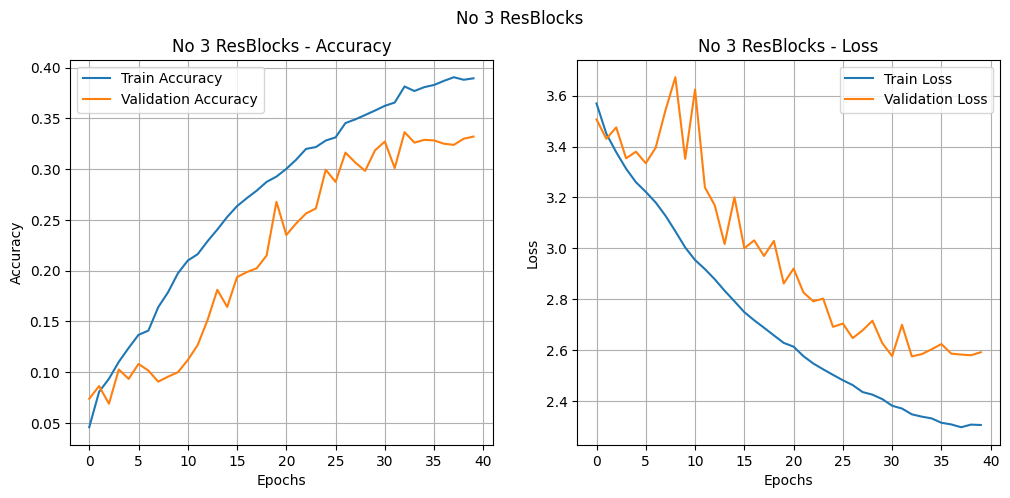

Ablation Without Three ResBlocks - Test Acc: 0.37432


In [ ]:
# Train the model without three ResBlocks
model_no_3_res = CustomResizeableResNet(num_classes=num_classes, num_max_layers=1).to(device).to(memory_format=torch.channels_last)
optimizer_no_3_res = optim.AdamW(model_no_3_res.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler_no_3_res = OneCycleLR(optimizer_no_3_res, max_lr=MAX_LEARNING_RATE, epochs=NUM_EPOCHS, steps_per_epoch=steps_per_epoch)

model_no_3_res, history_no_3_res, best_val_acc_no_3_res = train_model(
    model_no_3_res, dataloaders, criterion, optimizer_no_3_res, scheduler_no_3_res, num_epochs=NUM_EPOCHS
)
print(f"Ablation Without Three ResBlocks - Best val Acc: {best_val_acc_no_3_res:.5f}")
plot_history(history_no_3_res, "No 3 ResBlocks")

test_acc_no_3_res = evaluate_model(model_no_3_res, dataloaders['test'])
print(f"Ablation Without Three ResBlocks - Test Acc: {test_acc_no_3_res:.5f}")

## Ablation Study 3 - Dropout Removal

--------------------
Epoch 1/40
train Loss: 3.3405 Acc: 0.0994
val Loss: 3.2370 Acc: 0.1314
--------------------
Epoch 2/40
train Loss: 3.0920 Acc: 0.1628
val Loss: 3.1968 Acc: 0.1450
--------------------
Epoch 3/40
train Loss: 2.9039 Acc: 0.2201
val Loss: 3.4374 Acc: 0.1445
--------------------
Epoch 4/40
train Loss: 2.7219 Acc: 0.2725
val Loss: 3.1498 Acc: 0.2312
--------------------
Epoch 5/40
train Loss: 2.5303 Acc: 0.3218
val Loss: 2.8731 Acc: 0.2595
--------------------
Epoch 6/40
train Loss: 2.2882 Acc: 0.3987
val Loss: 2.7670 Acc: 0.3370
--------------------
Epoch 7/40
train Loss: 2.0552 Acc: 0.4731
val Loss: 2.5333 Acc: 0.4013
--------------------
Epoch 8/40
train Loss: 1.8404 Acc: 0.5428
val Loss: 2.2217 Acc: 0.4776
--------------------
Epoch 9/40
train Loss: 1.6870 Acc: 0.5953
val Loss: 2.3620 Acc: 0.4793
--------------------
Epoch 10/40
train Loss: 1.5364 Acc: 0.6485
val Loss: 2.3007 Acc: 0.4417
--------------------
Epoch 11/40
train Loss: 1.3854 Acc: 0.6998
val Loss: 1.896

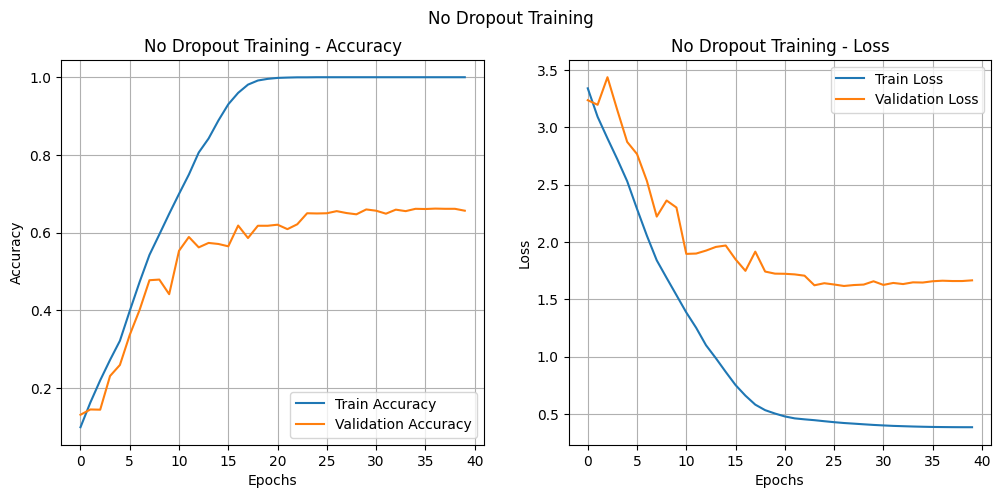

Ablation No Dropout - Test Acc: 0.68689


In [ ]:
# Use the original CustomResNet but setting dropout p=0.0
class CustomResNetNoDropout(nn.Module):
    def __init__(self, num_classes=37, depths=(2,2,2,2), width=1.0):
        super().__init__()
        w = lambda c: max(8, int(round(c * width)))
        self.stem = nn.Sequential(
            nn.Conv2d(3, w(64), 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(w(64)),
            nn.ReLU(inplace=True),
        )
        self.layer1 = make_layer(PreActBasicBlock, w(64), w(64), depths[0], stride_first=1)
        self.layer2 = make_layer(PreActBasicBlock, w(64), w(128), depths[1], stride_first=2)
        self.layer3 = make_layer(PreActBasicBlock, w(128), w(256), depths[2], stride_first=2)
        self.layer4 = make_layer(PreActBasicBlock, w(256), w(512), depths[3], stride_first=2)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.0)
        self.fc = nn.Linear(w(512), num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

model_no_dropout = CustomResNetNoDropout(num_classes=num_classes).to(device).to(memory_format=torch.channels_last)
optimizer_no_dropout = optim.AdamW(model_no_dropout.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler_no_dropout = OneCycleLR(optimizer_no_dropout, max_lr=MAX_LEARNING_RATE, epochs=NUM_EPOCHS, steps_per_epoch=steps_per_epoch)

model_no_dropout, history_no_dropout, best_val_acc_no_dropout = train_model(
    model_no_dropout, dataloaders, criterion, optimizer_no_dropout, scheduler_no_dropout, num_epochs=NUM_EPOCHS
)
print(f"Ablation No Dropout - Best val Acc: {best_val_acc_no_dropout:.5f}")
plot_history(history_no_dropout, "No Dropout Training")

test_acc_no_dropout = evaluate_model(model_no_dropout, dataloaders['test'])
print(f"Ablation No Dropout - Test Acc: {test_acc_no_dropout:.5f}")

# Experiments Results

| Experiment    | Train Accuracy | Validation Accuracy | Test Accuracy | Training Time
| - | - | - | - | - |
| Normal Training  | 1.0 | 0.6739 | 0.714 | 148m 24s |
| No BatchNorm | 1.0 | 0.452 | 0.513 | 124m 54s |
| Just 3 ResBlocks | 0.862 | 0.584 | 0.598 | 104m 31s |
| Just 2 ResBlocks | 0.704 | 0.467 | 0.499 | 83m 17s |
| Just 1 ResBlock | 0.389 | 0.336 | 0.374 | 57m 43s |
| No Dropout | 1.0 | 0.661 | 0.686 | 149m 58s |

The ablation study reveals the critical importance of architectural components in achieving high performance on the task:

- The Normal Training model (baseline), as expected, achieved the highest performance, setting the benchmark with an accuracy of 71.4%.

- The BatchNorm removal experiment showed a big drop of ~20% in the test accuracy, this underscores BatchNorm's essential role in stabilizing and accelerating training, and improving generalization, moreover, its important to notice that in this Pre-Activation architecture we choose, the batchnorm is particularly important, indeed, the removal of BatchNorm in a standard ResBlock would probably cause less impact over the performances.

- The progressive reduce of the number of ResBlocks from three down to one, resulted in a consistent decline in performance, with the one-block model achieving only 37.4% over the test set. This confirms that the deeper architecture provided richer feature extraction necessary for the complex classification task. An interesting extend of this experiment would have been over a way bigger network, indeed, as studied in the course, residual networks have a "redundancy" capability due to their ensable nature, and what would have been expected was a nearly absent decrease of performance with few removed layers, while having a bigger fall, removing more and more layers.

- Finally, the removal of the Dropout regulaization had a negligible impact on validation and test accuracy (68.6% test accuracy vs 71.4% baseline), suggesting that the other regularization techniques (like BatchNorm) were sufficient, or that the model was not significantly overfitting when the full architecture was used.

In terms of efficiency, all ablated models reduced training time, as expected due to simpler architectures or fewer operations per layer.

# Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained ResNet-18 model on `OxfordPetDataset`. Use the implementation provided by PyTorch, i.e. the opposite of part 1. Specifically, use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

2A. First, fine-tune the ResNet-18 with the same training hyperparameters you used for your best model in part 1.

2B. Then, tweak the training hyperparameters in order to increase the accuracy on the test split. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions — papers, blog posts, YouTube videos, or whatever else you may find useful. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~90%.

### Dataset Clarification
As this task require to fine-tune a pretrained ResNet-18 model on the original OxforPetDataset, the final evaluation will be done on that set of data, but as interesting comparison, a separate evaluation has been done also on our augmented version.

### ResNet-18 Model Load

For the first part, we fine-tune the ResNet-18 model pretrained on ImageNet-1K, we set out with the backbone for ResNet18-Weights IMAGENET1K_V1 and substitute the final classification layer to output 37 classes.


In [15]:
def build_resnet18_finetune(freeze_backbone, num_classes=37):
    weights = ResNet18_Weights.IMAGENET1K_V1
    model = resnet18(weights=weights)
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)

    if freeze_backbone:
        for name, p in model.named_parameters():
            if not name.startswith('fc'):
                p.requires_grad = False
    return model, weights

## 2A - ResNet18 Fine-Tune

For this part, 4 training experiments have been conducted with different conditions:
1. Augmented Dataset + No Freeze: Our augmented dataset is used for the fine-tuning, and none of the layers is frozen.
2. Original Dataset + No Freeze: The original dataset is used, and none of the layers is frozen.
3. Augmented Dataset + Feature Extraction Freeze: Our augmented dataset is used, and the first part of feature extraction of the network is frozen, such that only the final classification part is trained.
4. Original Dataset + Feature Extraction Freeze: The original dataset is used, and the first part of feature extraction of the network is frozen, such that only the final classification part is trained.

also, to ensure comparability with Part 1, we keep to the same training configuration.

To create a baseline for results comparison, two inferences of each dataset over the zero-shot version of the model has been done.

### Zero-Shot Baseline

In [ ]:
model, weights = build_resnet18_finetune(freeze_backbone=False)
model = model.to(device).to(memory_format=torch.channels_last)

print("Original Dataset:")
print("Train Acc:", evaluate_model(model, dataloaders_original['train']))
print("Validation Acc:", evaluate_model(model, dataloaders_original['val']))
print("Test Acc:", evaluate_model(model, dataloaders_original['test']))

print("Augmented Dataset:")
print("Train Acc:", evaluate_model(model, dataloaders['train']))
print("Validation Acc:", evaluate_model(model, dataloaders['val']))
print("Test Acc:", evaluate_model(model, dataloaders['test']))

Original Dataset:
Train Acc: 0.03488689016080676
Validation Acc: 0.02835332606324973
Test Acc: 0.03954496208017334
Augmented Dataset:
Train Acc: 0.033136296464703875
Validation Acc: 0.02835332606324973
Test Acc: 0.03954496208017334


### Fine Tuning with our Augmented Dataset (Full Network's weights)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


--------------------
Epoch 1/40
train Loss: 1.1511 Acc: 0.7850
val Loss: 1.0274 Acc: 0.7906
--------------------
Epoch 2/40
train Loss: 0.7317 Acc: 0.9060
val Loss: 1.1940 Acc: 0.7585
--------------------
Epoch 3/40
train Loss: 0.8112 Acc: 0.8771
val Loss: 1.3639 Acc: 0.6810
--------------------
Epoch 4/40
train Loss: 0.9522 Acc: 0.8296
val Loss: 1.4392 Acc: 0.6881
--------------------
Epoch 5/40
train Loss: 1.0208 Acc: 0.8061
val Loss: 1.7977 Acc: 0.5851
--------------------
Epoch 6/40
train Loss: 1.0653 Acc: 0.7947
val Loss: 1.7219 Acc: 0.6439
--------------------
Epoch 7/40
train Loss: 1.0511 Acc: 0.7987
val Loss: 1.6662 Acc: 0.6456
--------------------
Epoch 8/40
train Loss: 1.0040 Acc: 0.8163
val Loss: 1.6425 Acc: 0.6379
--------------------
Epoch 9/40
train Loss: 0.9291 Acc: 0.8387
val Loss: 1.7567 Acc: 0.5971
--------------------
Epoch 10/40
train Loss: 0.8560 Acc: 0.8626
val Loss: 1.8492 Acc: 0.5845
--------------------
Epoch 11/40
train Loss: 0.7733 Acc: 0.8901
val Loss: 1.735

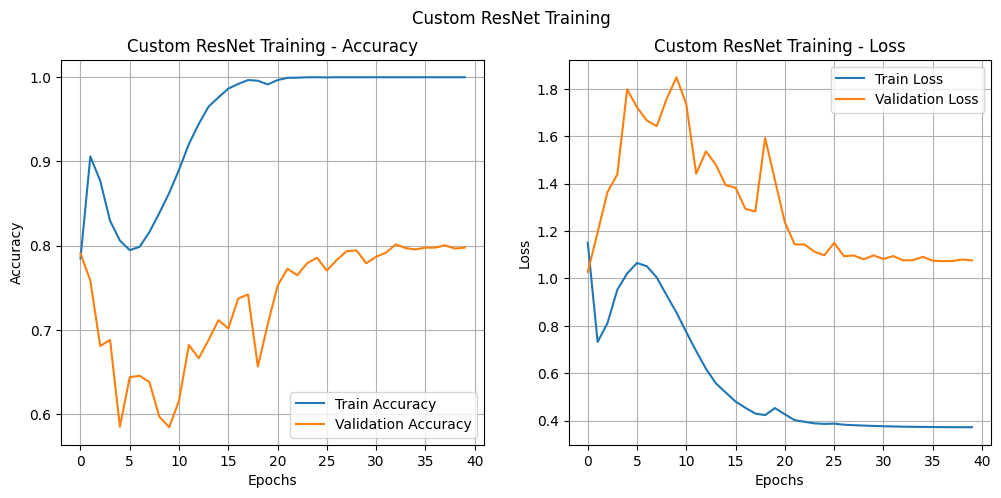

Model saved to /content/drive/MyDrive/colab_models/resnet18_weights_finetuned.pth


In [ ]:
model, weights = build_resnet18_finetune(freeze_backbone=False)
model = model.to(device).to(memory_format=torch.channels_last)

criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

steps_per_epoch = len(dataloaders['train'])
scheduler = OneCycleLR(optimizer, max_lr=MAX_LEARNING_RATE,
                       epochs=NUM_EPOCHS, steps_per_epoch=steps_per_epoch)


model, history, last_epoch_idx = train_model(
    model, dataloaders, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS
)
print("Test Acc:", evaluate_model(model, dataloaders['test']))

plot_history(history, "Custom ResNet Training")

os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_SAVE_PATH = os.path.join(MODEL_DIR, 'resnet18_weights_finetuned_AUG_FN.pth')
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

### Fine Tuning with Original Dataset (Full Network's weights)

--------------------
Epoch 1/40
train Loss: 1.5721 Acc: 0.7026
val Loss: 0.9913 Acc: 0.8201
--------------------
Epoch 2/40
train Loss: 0.6373 Acc: 0.9392
val Loss: 1.1744 Acc: 0.7563
--------------------
Epoch 3/40
train Loss: 0.6122 Acc: 0.9458
val Loss: 1.7966 Acc: 0.5987
--------------------
Epoch 4/40
train Loss: 0.7678 Acc: 0.8869
val Loss: 2.0386 Acc: 0.5322
--------------------
Epoch 5/40
train Loss: 0.9591 Acc: 0.8272
val Loss: 2.0978 Acc: 0.4962
--------------------
Epoch 6/40
train Loss: 1.0369 Acc: 0.7972
val Loss: 3.1917 Acc: 0.3304
--------------------
Epoch 7/40
train Loss: 1.0870 Acc: 0.7890
val Loss: 2.7010 Acc: 0.4144
--------------------
Epoch 8/40
train Loss: 1.0835 Acc: 0.7890
val Loss: 2.7630 Acc: 0.3419
--------------------
Epoch 9/40
train Loss: 1.0981 Acc: 0.7855
val Loss: 2.7393 Acc: 0.3659
--------------------
Epoch 10/40
train Loss: 1.0333 Acc: 0.8029
val Loss: 2.7801 Acc: 0.3986
--------------------
Epoch 11/40
train Loss: 0.9259 Acc: 0.8455
val Loss: 2.633

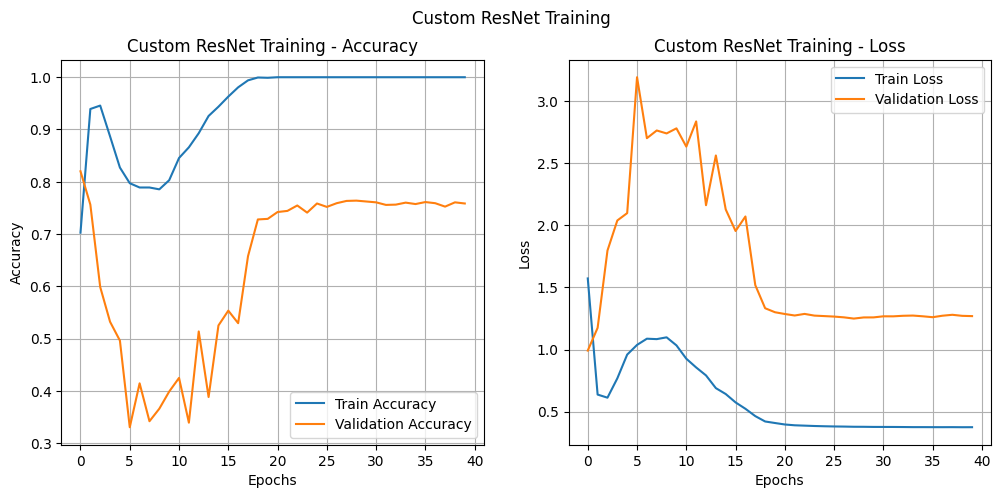

Model saved to /content/drive/MyDrive/colab_models/resnet18_weights_finetuned.pth


In [ ]:
model, weights = build_resnet18_finetune(freeze_backbone=False)
model = model.to(device).to(memory_format=torch.channels_last)

criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

steps_per_epoch = len(dataloaders_original['train'])
scheduler = OneCycleLR(optimizer, max_lr=MAX_LEARNING_RATE,
                       epochs=NUM_EPOCHS, steps_per_epoch=steps_per_epoch)


model, history, last_epoch_idx = train_model(
    model, dataloaders_original, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS
)
print("Test Acc:", evaluate_model(model, dataloaders_original['test']))

plot_history(history, "Custom ResNet Training")

os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_SAVE_PATH = os.path.join(MODEL_DIR, 'resnet18_weights_finetuned_ORIG_FN.pth')
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

### Fine Tuning with our Augmented Dataset (Frozen Backbone)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


--------------------
Epoch 1/40
train Loss: 2.5983 Acc: 0.4456
val Loss: 1.5108 Acc: 0.7590
--------------------
Epoch 2/40
train Loss: 1.3904 Acc: 0.7701
val Loss: 0.9831 Acc: 0.8451
--------------------
Epoch 3/40
train Loss: 1.0679 Acc: 0.8187
val Loss: 0.9102 Acc: 0.8522
--------------------
Epoch 4/40
train Loss: 0.9702 Acc: 0.8389
val Loss: 0.9186 Acc: 0.8544
--------------------
Epoch 5/40
train Loss: 0.9251 Acc: 0.8526
val Loss: 0.9522 Acc: 0.8299
--------------------
Epoch 6/40
train Loss: 0.8987 Acc: 0.8584
val Loss: 0.9946 Acc: 0.8353
--------------------
Epoch 7/40
train Loss: 0.8909 Acc: 0.8603
val Loss: 1.0835 Acc: 0.7993
--------------------
Epoch 8/40
train Loss: 0.8860 Acc: 0.8638
val Loss: 1.0953 Acc: 0.8108
--------------------
Epoch 9/40
train Loss: 0.8894 Acc: 0.8610
val Loss: 1.0513 Acc: 0.8293
--------------------
Epoch 10/40
train Loss: 0.8848 Acc: 0.8670
val Loss: 1.1717 Acc: 0.8053
--------------------
Epoch 11/40
train Loss: 0.8851 Acc: 0.8669
val Loss: 1.138

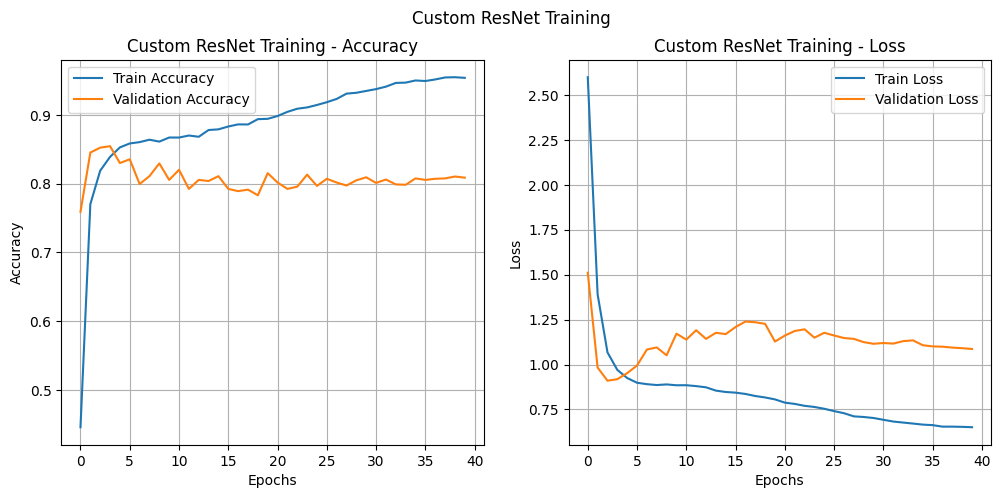

Model saved to /content/drive/MyDrive/colab_models/resnet18_weights_finetuned.pth


In [ ]:
model, weights = build_resnet18_finetune(freeze_backbone=True)
model = model.to(device).to(memory_format=torch.channels_last)

criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

steps_per_epoch = len(dataloaders['train'])
scheduler = OneCycleLR(optimizer, max_lr=MAX_LEARNING_RATE,
                       epochs=NUM_EPOCHS, steps_per_epoch=steps_per_epoch)


model, history, last_epoch_idx = train_model(
    model, dataloaders, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS
)
print("Test Acc:", evaluate_model(model, dataloaders['test']))

plot_history(history, "Custom ResNet Training")

os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_SAVE_PATH = os.path.join(MODEL_DIR, 'resnet18_weights_finetuned_AUG_FFE.pth')
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

### Fine Tuning with Original Dataset (Frozen Backbone)

--------------------
Epoch 1/40
train Loss: 3.3141 Acc: 0.1922
val Loss: 2.8506 Acc: 0.3806
--------------------
Epoch 2/40
train Loss: 2.3202 Acc: 0.6045
val Loss: 1.8817 Acc: 0.6827
--------------------
Epoch 3/40
train Loss: 1.4445 Acc: 0.8087
val Loss: 1.2389 Acc: 0.8124
--------------------
Epoch 4/40
train Loss: 0.9845 Acc: 0.8749
val Loss: 1.0103 Acc: 0.8233
--------------------
Epoch 5/40
train Loss: 0.8366 Acc: 0.8874
val Loss: 0.9287 Acc: 0.8277
--------------------
Epoch 6/40
train Loss: 0.7558 Acc: 0.9117
val Loss: 0.8979 Acc: 0.8506
--------------------
Epoch 7/40
train Loss: 0.7171 Acc: 0.9177
val Loss: 0.9302 Acc: 0.8397
--------------------
Epoch 8/40
train Loss: 0.6896 Acc: 0.9357
val Loss: 0.9548 Acc: 0.8375
--------------------
Epoch 9/40
train Loss: 0.6688 Acc: 0.9351
val Loss: 0.9514 Acc: 0.8326
--------------------
Epoch 10/40
train Loss: 0.6659 Acc: 0.9368
val Loss: 1.0523 Acc: 0.7955
--------------------
Epoch 11/40
train Loss: 0.6320 Acc: 0.9504
val Loss: 1.049

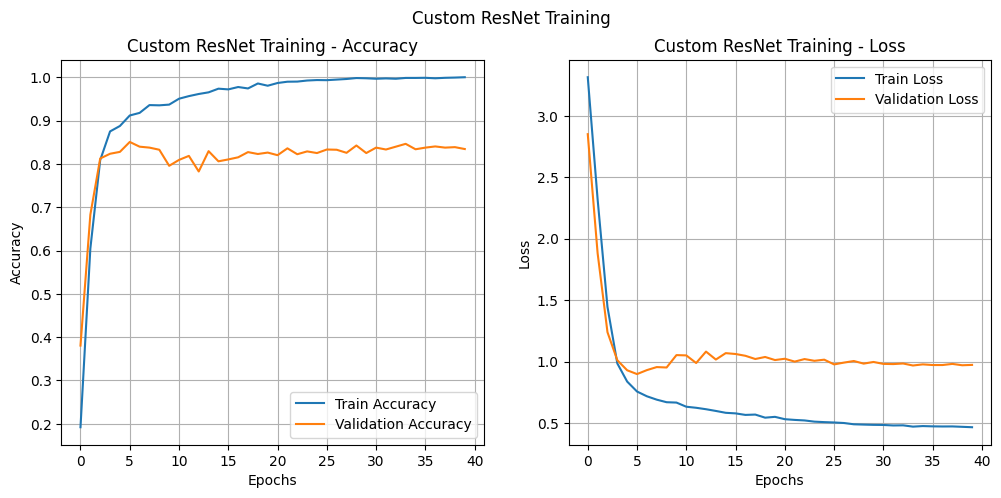

Model saved to /content/drive/MyDrive/colab_models/resnet18_weights_finetuned.pth


In [ ]:
model, weights = build_resnet18_finetune(freeze_backbone=True)
model = model.to(device).to(memory_format=torch.channels_last)

criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

steps_per_epoch = len(dataloaders_original['train'])
scheduler = OneCycleLR(optimizer, max_lr=MAX_LEARNING_RATE,
                       epochs=NUM_EPOCHS, steps_per_epoch=steps_per_epoch)


model, history, last_epoch_idx = train_model(
    model, dataloaders_original, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS
)
print("Test Acc:", evaluate_model(model, dataloaders_original['test']))

plot_history(history, "Custom ResNet Training")

os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_SAVE_PATH = os.path.join(MODEL_DIR, 'resnet18_weights_finetuned_ORIG_FFE.pth')
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

### Results
| Experiment    | Train Accuracy | Validation Accuracy | Test Accuracy | Training Time
| - | - | - | - | - |
| Zero-Shot (Augmented set)  | 0.031 | 0.028 | 0.039 | - |
| Zero-Shot (Original set)  | 0.034 | 0.028 | 0.039 | - |
| Fine-Tune Augmented set + No Freeze | 1.0 | 0.797 | 0.821 | 27m 58s |
| Fine-Tune Original set + No Freeze | 1.0 | 0.758 | 0.843 | 18m 42s |
| Fine-Tune Augmented set + Feature-Extraction Freeze | 0.953 | 0.806 | 0.864 | 24m 9s |
| Fine-Tune Augmented set + Feature-Extraction Freeze | 1.0 | 0.834 | 0.862 | 17m 55s |

As expected, the Zero-Shot accuracy results were quite low, while all fine-tuning configurations led to significantly improved performance.
From the table, we can observe that the “No Freeze” experiments achieved, on average, approximately 3% lower accuracy compared to the “Feature-Extraction Freeze” configurations, this suggests that preserving the pretrained feature extractor provided a more effective representation for our task than fully updating the model’s parameters.

All four training experiments exhibited signs of overfitting to the training data, notably, the “Feature-Extraction Freeze” models began overfitting after only 5 of the 40 training epochs, indicating that the model quickly reached its maximum capacity for generalization under this configuration. This behavior implies that while freezing the feature extractor accelerates convergence, it may also limit the model’s ability to adapt to domain-specific variations in the dataset.

# 2B - ResNet Fine-Tune Optimization

The goal of this optimization phase was to improve the performance of the fine-tuning and achieve the target test accuracy of ~90%, as asked from the task, the tuning focused solely on adjusting key hyperparameters of the training process: the base learning rate, the maximum learning rate for the scheduler, weight decay, and label smoothing.

From the results table of the 2A experiments, we noticed how the model quickly overfitted the training data in all of the fine-tunings, making harder for it to further generalize, and improve the validation/test score, and once this state is reached, increasing the number of training epochs becomes an ineffective strategy for performance improvement.

To counteract this, the primary strategy was to increase regularization, the weight decay parameter was increased to impose a stronger L2 penalty on the weights, and similarly, label smoothing was increased to promote better generalization by preventing the model from becoming overly confident in its predictions.
After adjusting the regularization, the learning rate parameters for the scheduler were consequently refined to maintain stable and efficient convergence.

The final optimized hyperparameter values are summarized below:
- Weight Decay: 3e-4 &#8594; 4e-4
- Label Smoothing: 0.05 &#8594; 0.1
- Learning Rate: 3e-3 &#8594; 11e-5
- Max Learning Rate: Learninig Rate * 2 &#8594; Learninig Rate * 3

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 206MB/s]


--------------------
Epoch 1/40
train Loss: 3.7181 Acc: 0.1590
val Loss: 3.6385 Acc: 0.1680
--------------------
Epoch 2/40
train Loss: 3.5277 Acc: 0.2401
val Loss: 3.4262 Acc: 0.3496
--------------------
Epoch 3/40
train Loss: 3.2838 Acc: 0.4591
val Loss: 3.1333 Acc: 0.4703
--------------------
Epoch 4/40
train Loss: 2.9326 Acc: 0.7301
val Loss: 2.7396 Acc: 0.7831
--------------------
Epoch 5/40
train Loss: 2.4908 Acc: 0.7277
val Loss: 2.2895 Acc: 0.7478
--------------------
Epoch 6/40
train Loss: 2.0467 Acc: 0.8014
val Loss: 1.8948 Acc: 0.8075
--------------------
Epoch 7/40
train Loss: 1.6818 Acc: 0.8100
val Loss: 1.6129 Acc: 0.8112
--------------------
Epoch 8/40
train Loss: 1.4208 Acc: 0.8553
val Loss: 1.4279 Acc: 0.8266
--------------------
Epoch 9/40
train Loss: 1.2814 Acc: 0.8787
val Loss: 1.3300 Acc: 0.8413
--------------------
Epoch 10/40
train Loss: 1.1818 Acc: 0.8937
val Loss: 1.2673 Acc: 0.8557
--------------------
Epoch 11/40
train Loss: 1.1250 Acc: 0.9076
val Loss: 1.237

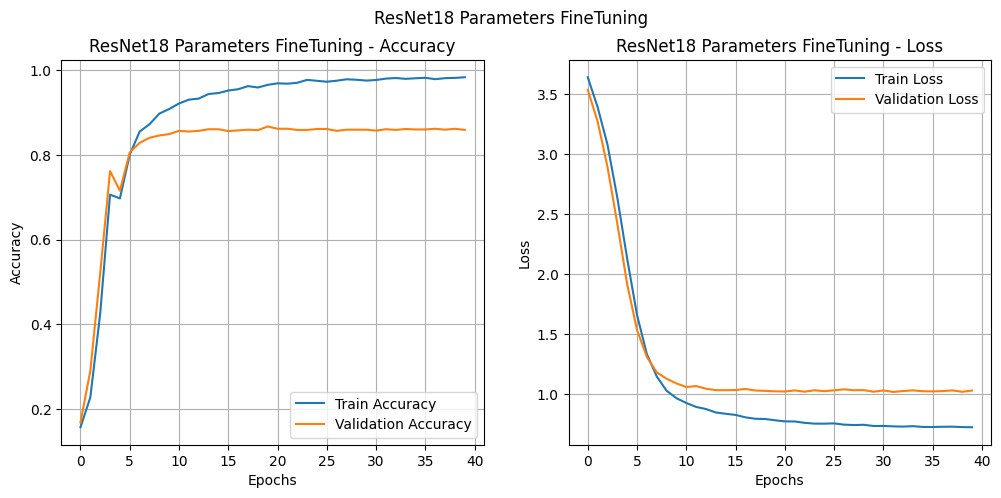

Model saved to /content/drive/MyDrive/colab_models/resnet18_weights_finetuned_PARAM_TUNING.pth


In [ ]:
LEARNING_RATE = 11e-5
MAX_LEARNING_RATE = LEARNING_RATE * 3
WEIGHT_DECAY = 4e-4
LABEL_SMOOTHING = 0.1

model, weights = build_resnet18_finetune(freeze_backbone=True)
model = model.to(device).to(memory_format=torch.channels_last)

criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

steps_per_epoch = len(dataloaders_original['train'])
scheduler = OneCycleLR(optimizer, max_lr=MAX_LEARNING_RATE,
                       epochs=NUM_EPOCHS, steps_per_epoch=steps_per_epoch)

model, history, last_epoch_idx = train_model(
    model, dataloaders_original, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS
)
print("Test Acc:", evaluate_model(model, dataloaders_original['test']))

plot_history(history, "ResNet18 Parameters FineTuning")

os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_SAVE_PATH = os.path.join(MODEL_DIR, 'resnet18_weights_finetuned_PARAM_TUNING.pth')
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

The optimized fine-tuning archieved 89.68% over the test set, in line with the target goal of ~90%, this represents an increase of 3.2% over the previous best result demonstrating the effectiveness of the optimizations.